In [ ]:
from google.colab import drive
drive.mount('/content/drive')

#Training wit annotated dataset.

In [ ]:
FOLDER_NAME = "annotated"

!unzip "/content/drive/MyDrive/{FOLDER_NAME}.zip" -d "/content"

In [3]:
import numpy as np
import glob
import cv2
from torch.utils.data import Dataset, random_split

file_names = glob.glob(FOLDER_NAME + "/*.jpg")

class ImageDataset(Dataset):
  def __len__(self):
    return len(file_names)

  def __getitem__(self, idx):
    img = cv2.imread(file_names[idx], 0)
    mask = np.load(file_names[idx].replace(".jpg", "_seg.npy"), allow_pickle=True).item()["masks"]
    return img, mask

dataset = ImageDataset()

training_dataset, test_dataset = random_split(dataset, [0.8, 0.2])

In [ ]:
%pip install cellpose==3.0.8

In [19]:
# Getting training and test data into memory.
# In future maybe an own training loop can be implemented if memory is not enough.
training_images, training_masks = [], []

for image, mask in training_dataset:
  training_images.append(image)
  training_masks.append(mask)

test_images, test_masks = [], []
for image, mask in test_dataset:
  test_images.append(image)
  test_masks.append(mask)

In [67]:
from cellpose import models, train, utils, transforms, dynamics
from tqdm import trange
import torch
import logging

def train_model(model_type, n_epochs):
  logger = logging.getLogger('cellpose')
  logger.setLevel(logging.DEBUG)

  model = models.CellposeModel(model_type=model_type, gpu=torch.cuda.is_available())
  test_labels = dynamics.labels_to_flows(test_masks, device=model.net.device)

  train.train_seg(
              model.net, n_epochs=n_epochs,
              train_data=training_images, train_labels=training_masks,
              test_data=test_images, test_labels=test_masks,
              channels=[0, 0], normalize=True,
              weight_decay=1e-4, SGD=True, learning_rate=0.1,
              save_path="/content/drive/MyDrive/cellpose-cell-counting", model_name=f"{model_type}")

In [58]:
train_model("cyto3", n_epochs = 1000)

INFO:cellpose.models:>> cyto3 << model set to be used
INFO:cellpose.core:** TORCH CUDA version installed and working. **
INFO:cellpose.core:>>>> using GPU
INFO:cellpose.models:>>>> loading model /root/.cellpose/models/cyto3
INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
INFO:cellpose.dynamics:computing flows for labels
100%|██████████| 3/3 [00:01<00:00,  1.77it/s]
INFO:cellpose.dynamics:computing flows for labels
100%|██████████| 13/13 [00:08<00:00,  1.54it/s]
INFO:cellpose.dynamics:computing flows for labels
100%|██████████| 3/3 [00:01<00:00,  1.72it/s]
INFO:cellpose.train:>>> computing diameters
100%|██████████| 3/3 [00:00<00:00, 220.19it/s]
INFO:cellpose.train:>>> using channels [0, 0]
INFO:cellpose.train:>>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': False, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}
INFO:cellpose.train:>>> n_epochs=

#Testing with the dataset where the cell counts are needed.

In [3]:
CELL_COUNTING_FOLDER_NAME = "2024.05.09. Ac-kPHSRN+fibronektin"
MODEL_NAME = "cyto3"

!unzip "/content/drive/MyDrive/{CELL_COUNTING_FOLDER_NAME}.zip" -d "/content"

Archive:  /content/drive/MyDrive/2024.05.09. Ac-kPHSRN+fibronektin.zip
replace /content/2024.05.09. Ac-kPHSRN+fibronektin/115.1w.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [27]:
import numpy as np
from torch.utils.data import Dataset
import glob
import cv2

file_names = glob.glob(CELL_COUNTING_FOLDER_NAME + "/*.jpg")

class CellCountingDataset(Dataset):
  def __len__(self):
    return len(file_names)

  def __getitem__(self, idx):
    img = cv2.imread(file_names[idx], 0)
    return img

dataset = CellCountingDataset()

In [26]:
from cellpose import models
import torch

model = models.CellposeModel(
    pretrained_model=f"/content/drive/MyDrive/cellpose-cell-counting/models/{MODEL_NAME}",
    gpu=torch.cuda.is_available())

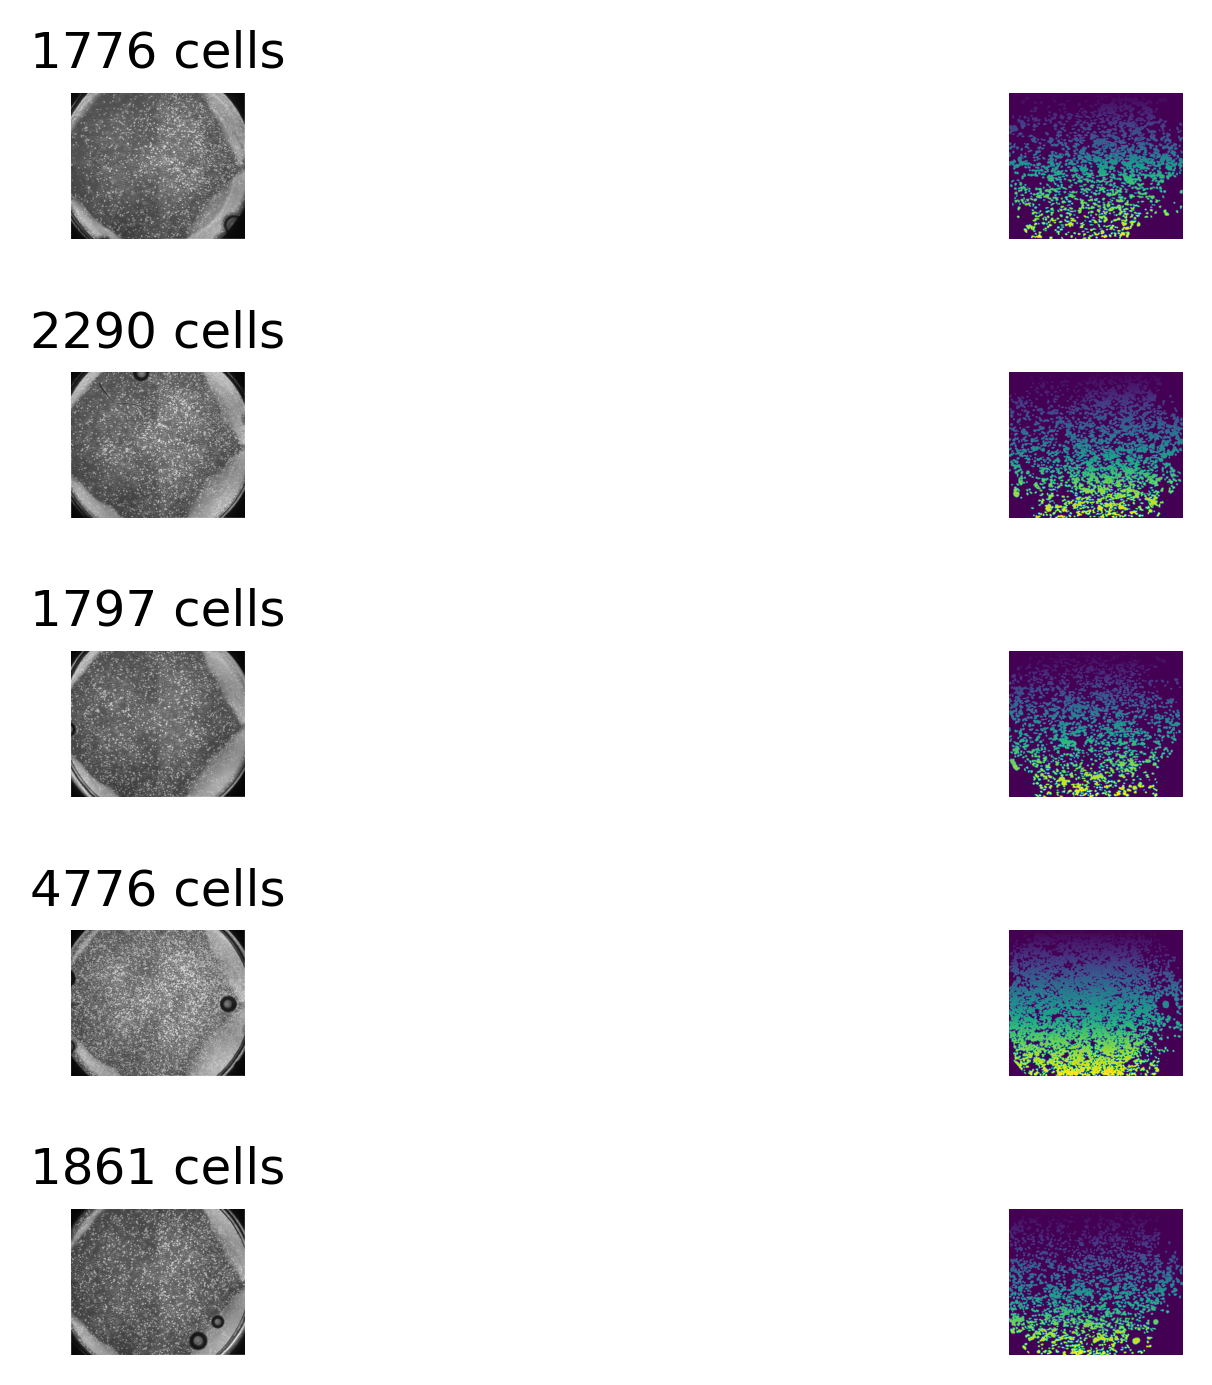

In [40]:
import matplotlib.pyplot as plt

# Increase this flow threshold if cellpose is not returning as many ROIs as you’d expect.
# Similarly, decrease this threshold if cellpose is returning too many ill-shaped ROIs.
#
# Decrease cellprob threshold if cellpose is not returning as many ROIs as you’d expect.
# Similarly, increase this threshold if cellpose is returning too ROIs particularly from dim areas.
FLOW_THRESHOLD = 0.4
CELLPROB_THRESHOLD = 0.0

NUM_EXAMPLES = 5
ids = np.random.randint(0, len(dataset), size=NUM_EXAMPLES)

fig, ax = plt.subplots(nrows=NUM_EXAMPLES, ncols=2, dpi=300)
fig.tight_layout()

for i in range(NUM_EXAMPLES):
  mask, _, _ = model.eval(
      dataset[ids[i]],
      diameter=None,
      channels=[0, 0],
      flow_threshold=FLOW_THRESHOLD,
      cellprob_threshold=CELLPROB_THRESHOLD)

  cell_cnt = np.max(mask)

  ax[i][0].title.set_text(f"{cell_cnt} cells")
  ax[i][0].axis("off")
  ax[i][0].imshow(dataset[ids[i]], cmap="gray");

  ax[i][1].axis("off")
  ax[i][1].imshow(mask)